In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
jtplot.style()

In [3]:
def getlogs(server):
    """Get server logs and format for analysis"""
    x = pd.read_csv(f'../data/slurm_wrapper_{server}.log', 
                      sep = ' - ', 
                      engine = 'python', 
                      names = ['DATETIME', 'USER', 'RETRY', 'TIMELAPSE', 'RETURNCODE', 'COMMAND'])
    x['DATETIME'] = pd.to_datetime(x['DATETIME'])
    x['USER'] = x['USER'].str.extract(r'(\d+)')
    x['RETRY'] = x['RETRY'].str.extract('(\d+)').astype('int')
    x['TIMELAPSE'] = x['TIMELAPSE'].str.replace('time ', '').astype('float')
    x['RETURNCODE'] = x['RETURNCODE'].str.extract('(\d+)')
    x['JOBID'] = x['COMMAND'].str.extract(r"'(\d{8})'")
    x['COMMANDTYPE'] = x['COMMAND'].str.extract(r"bin/(s\w+)'")
    x['TESTING'] = (x['COMMANDTYPE'] == 'sbatch') & (x['USER'] == '9204')
    x['UNRESPONSIVE'] = (x['TIMELAPSE'] >= 15) & (x['RETURNCODE'] == '1')
    x['SERVER'] = f'{server}'
    return x

In [4]:
ce5 = getlogs('ce5')
ce6 = getlogs('ce6')

In [5]:
ce = pd.concat([ce5, ce6]).sort_values('DATETIME').reset_index(drop = True)

# Problem 3

Calculate some descriptive statistics about 

(3A) how often the scheduler was unresponsive: 

   * Approximately 10.62% of the time overall
   * ce5 approximately 9.14% of the time
   * ce6 approximately 12.11% of the time

(3B) how long these periods of time were, and 

(3C) create a time series plot of when the scheduler was having difficulties.

## (3A) How often was the scheduler unresponsive?

### Answer

   * Approximately 10.62% of the time overall
   * ce5 approximately 9.14% of the time
   * ce6 approximately 12.11% of the time

In [6]:
# Write a function to show count and proportion of value_counts() simultaneously
def ct_prop(df, group):
    a = ce[group].value_counts().reset_index().rename(columns = {'index' : f'{group}', 'UNRESPONSIVE' : 'COUNT'})
    b = ce[group].value_counts(normalize = True).reset_index().rename(columns = {'index' : f'{group}', 'UNRESPONSIVE' : 'PROPORTION'})
    ab = a.merge(b)
    return ab

In [7]:
# Overall scheduler response vs unresponse
print('The scheduler is unresponsive approximately 10.62% of the time.')
ct_prop(ce, 'UNRESPONSIVE')

The scheduler is unresponsive approximately 10.62% of the time.


,UNRESPONSIVE,COUNT,PROPORTION
0,False,8533047,0.893755
1,True,1014366,0.106245


In [8]:
# Counts of response vs unresponse by server
ce.groupby(['SERVER', 'UNRESPONSIVE'])['UNRESPONSIVE'].count()

SERVER  UNRESPONSIVE
ce5     False           4335065
        True             435828
ce6     False           4197982
        True             578538
Name: UNRESPONSIVE, dtype: int64

In [9]:
# Scheduler unresponse by server
print('ce6 tends to be unresponsive significantly more often than ce5 (12.11% vs. 9.14)')
ce.groupby(['SERVER'])['UNRESPONSIVE'].mean()

ce6 tends to be unresponsive significantly more often than ce5 (12.11% vs. 9.14)


SERVER
ce5    0.091351
ce6    0.121121
Name: UNRESPONSIVE, dtype: float64

## Problem 3B: How long were the periods of unresponsiveness?

### Answer

* count                        87905
* mean     0 days 00:00:06.127988967
* std      0 days 00:00:39.957379362
* min                0 days 00:00:00
* 25%                0 days 00:00:00
* 50%         0 days 00:00:00.110372
* 75%         0 days 00:00:04.698021
* max         0 days 03:03:11.213543

In [10]:
counter = 0
def unresponsive_grouper(x):
    global counter
    if x == False:
        counter += 1
        entry = np.nan
    else:
        entry = counter
    return entry

In [11]:
ce['UNRESPONSIVEGROUP'] = ce['UNRESPONSIVE'].apply(unresponsive_grouper)

In [112]:
ce.to_csv('../data/ce.csv', index = False)

In [13]:
unresponsive_intervals = (ce.groupby('UNRESPONSIVEGROUP', as_index = False)
                          ['DATETIME']
                          .apply(lambda x: x.max() - x.min())
                          .rename(columns = {'DATETIME' : 'INTERVALLENGTH'})
                       )
unresponsive_intervals

,UNRESPONSIVEGROUP,INTERVALLENGTH
0,4396.0,0 days 00:00:03.591429
1,4408.0,0 days 00:00:00
2,17173.0,0 days 00:00:00
3,17299.0,0 days 00:00:00.383366
4,17542.0,0 days 00:00:00
...,...,...
87900,8514105.0,0 days 00:00:00
87901,8514106.0,0 days 00:00:00.047851
87902,8514108.0,0 days 00:00:00.107661
87903,8514109.0,0 days 00:00:00.139284


In [14]:
unresponsive_intervals['INTERVALLENGTH'].describe()

count                        87905
mean     0 days 00:00:06.127988967
std      0 days 00:00:39.957379362
min                0 days 00:00:00
25%                0 days 00:00:00
50%         0 days 00:00:00.110372
75%         0 days 00:00:04.698021
max         0 days 03:03:11.213543
Name: INTERVALLENGTH, dtype: object

[(1e-05, 1000.0)]

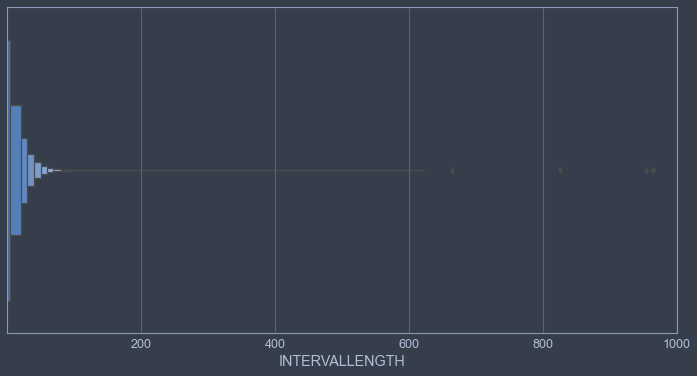

In [15]:
plt.subplots(figsize = (12, 6))
ax = sns.boxenplot(x = unresponsive_intervals['INTERVALLENGTH'].astype('timedelta64[s]'))
ax.set(xlim = (0.00001, 1000))

[None, (1e-05, 1000)]

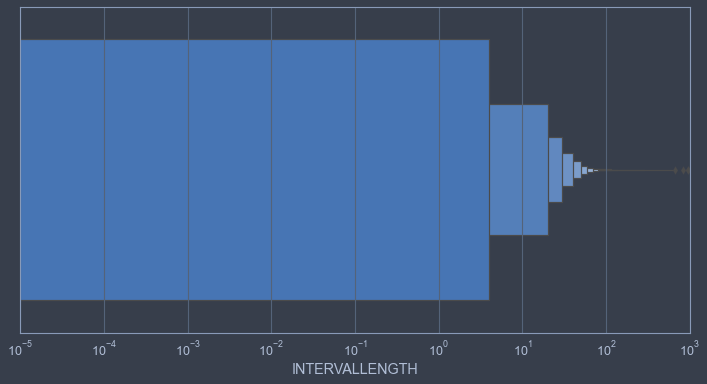

In [16]:
plt.subplots(figsize = (12, 6))
ax2 = sns.boxenplot(x = unresponsive_intervals['INTERVALLENGTH'].astype('timedelta64[s]'))
ax2.set(xscale = 'log', xlim = (0.00001, 1000))

## (3C) Create a time series plot of when the scheduler was having difficulties.